In [1]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# run_google_colab = True
run_google_colab = False


In [2]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "nc-time-axis", "cftime", "climpred", "dateutil", "seaborn",
]

if run_google_colab:
    # Install missing packages if needed
    for pkg in required_packages:
        install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator


In [3]:
if run_google_colab:
    # Download necessary files if running in Google Colab
    !wget -cq https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO.py
    !wget -cq https://github.com/senclimate/XRO/raw/main/code/XRO_utils.py

# def setup_module_path():
module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/XRO-main'
sys.path.append(module_path)

# Import necessary modules after ensuring files are available
from XRO import XRO, xcorr, SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm
# from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


In [4]:
# prepare NPP file
npp_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_photoC_TOT_zint_100m_x1_210_x2_270_y1_-20_y2_10.nc'
npp_ds = xr.open_dataset(npp_file).sel(time=slice('1979-01', '2023-12'))
# print(npp_ds)
clim = npp_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = npp_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_photoC_TOT_zint_100m'].values, deg=2)
trend = np.polyval(coeffs, t)
npp_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare SSH file
ssh_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_SSH_x1_210_x2_270_y1_-20_y2_10.nc'
ssh_ds = xr.open_dataset(ssh_file).sel(time=slice('1979-01', '2023-12'))
clim = ssh_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = ssh_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_SSH'].values, deg=2)
trend = np.polyval(coeffs, t)
ssh_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare SST file
sst_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_TEMP_x1_210_x2_270_y1_-20_y2_10.nc'
sst_ds = xr.open_dataset(sst_file).sel(time=slice('1979-01', '2023-12'))
clim = sst_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = sst_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_SST'].values, deg=2)
trend = np.polyval(coeffs, t)
sst_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# prepare MLD file
mld_file = '/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_HBLT_x1_210_x2_270_y1_-20_y2_10.nc'
mld_ds = xr.open_dataset(mld_file).sel(time_counter=slice('1979-01', '2023-12'))
mld_ds = mld_ds.rename({'time_counter': 'time'})
clim = mld_ds.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
anomalies = mld_ds.groupby("time.month") - clim
t = np.arange(anomalies.time.size)
coeffs = np.polyfit(t, anomalies['obs_HBLT'].values, deg=2)
trend = np.polyval(coeffs, t)
mld_ds = anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})


In [5]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
if run_google_colab:
    obs_file = './XRO_indices_oras5.nc'
else:
    # obs_file = '../data/XRO_indices_oras5.nc'
    obs_file = '/mnt/lustre/proj/kimyy/Dropbox/source/python/all/Modules/RO_practical-main/data/XRO_indices_oras5.nc'

obs_ds = xr.open_dataset(obs_file).sel(time=slice('1998-01', '2023-12'))
obs_RO_ds = obs_ds[['Nino34', 'WWV']]
# print(obs_RO_ds)
print(obs_ds)
obs_ds.time

<xarray.Dataset> Size: 16kB
Dimensions:  (time: 312)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2023-12-01
    month    (time) int32 1kB ...
Data variables:
    Nino34   (time) float32 1kB ...
    WWV      (time) float32 1kB ...
    NPMM     (time) float32 1kB ...
    SPMM     (time) float32 1kB ...
    IOB      (time) float32 1kB ...
    IOD      (time) float32 1kB ...
    SIOD     (time) float32 1kB ...
    TNA      (time) float32 1kB ...
    ATL3     (time) float32 1kB ...
    SASD     (time) float32 1kB ...


<xarray.DataArray 'time' (time: 312)> Size: 2kB
array(['1998-01-01T00:00:00.000000000', '1998-02-01T00:00:00.000000000',
       '1998-03-01T00:00:00.000000000', ..., '2023-10-01T00:00:00.000000000',
       '2023-11-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2023-12-01
    month    (time) int32 1kB ...

In [6]:
# obs + npp
npp = npp_ds['obs_photoC_TOT_zint_100m'].rename('NPP')
npp_on_obs_time = npp.reindex(time=obs_RO_ds.time)
obs_ds_with_npp = obs_ds.copy()
obs_ds_with_npp['NPP'] = npp_on_obs_time

# obs + npp + ssh
ssh = ssh_ds['obs_SSH'].rename('SSH')
ssh_on_obs_time = ssh.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_ssh = obs_ds_with_npp.copy()
obs_ds_with_ssh['SSH'] = ssh_on_obs_time

# obs + npp + ssh + sst
# sst = sst_ds['obs_SST'].rename('SST')
# sst_on_obs_time = sst.reindex(time=obs_RO_ds.time)
# obs_ds_with_all = obs_ds_with_ssh.copy()
# obs_ds_with_all['SST'] = sst_on_obs_time

# mld = mld_ds['obs_HBLT'].rename('MLD').rename({'time_counter': 'time'})
mld = mld_ds['obs_HBLT'].rename('MLD')
mld_on_obs_time = mld.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_mld = obs_ds_with_ssh.copy()
obs_ds_with_mld['MLD'] = mld_on_obs_time

sst = sst_ds['obs_SST'].rename('SST')
sst_on_obs_time = sst.reindex(time=obs_RO_ds.time, method='nearest', tolerance='20D')
obs_ds_with_all = obs_ds_with_mld.copy()
obs_ds_with_all['SST'] = sst_on_obs_time


In [7]:
# File path

ds = obs_ds_with_all
# Variables to preprocess
varnames = ["SST", "NPP", "SSH", "MLD"]

# Function to remove monthly climatology (1980–2010) and quadratic trend
def deseason_detrend(da):
    # 1️⃣ Monthly climatology (1980–2010)
    # clim = da.sel(time=slice("1980-01-01", "2010-12-31")).groupby("time.month").mean("time")
    clim = da.sel(time=slice("1998-01-01", "2023-12-31")).groupby("time.month").mean("time")
    anomalies = da.groupby("time.month") - clim

    # 2️⃣ Quadratic trend (full period)
    t = np.arange(anomalies.time.size)
    coeffs = np.polyfit(t, anomalies.values, deg=2)
    trend = np.polyval(coeffs, t)

    return anomalies - xr.DataArray(trend, dims=["time"], coords={"time": anomalies.time})

# Apply preprocessing for each variable
processed_vars = {}
for v in varnames:
    print(f"Processing {v} ...")
    processed_vars[v] = deseason_detrend(ds[v])

# Merge processed variables into one dataset
ds_processed = xr.Dataset(processed_vars)

ds_processed

ds_processed


Processing SST ...
Processing NPP ...
Processing SSH ...
Processing MLD ...


<xarray.Dataset> Size: 14kB
Dimensions:  (time: 312)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2023-12-01
    month    (time) int32 1kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    SST      (time) float64 2kB 1.855 1.601 1.6 1.017 ... 1.169 1.228 1.228
    NPP      (time) float64 2kB -93.48 -92.75 -108.9 -96.6 ... 20.94 23.1 -1.796
    SSH      (time) float64 2kB 0.1355 0.1146 0.08627 ... 0.03517 0.04502
    MLD      (time) float64 2kB 3.849 4.93 4.648 1.398 ... -3.878 7.102 6.112

In [8]:
obs_all = xr.merge([obs_ds, ds_processed])
obs_all

<xarray.Dataset> Size: 26kB
Dimensions:  (time: 312)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2023-12-01
    month    (time) int32 1kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables: (12/14)
    Nino34   (time) float32 1kB ...
    WWV      (time) float32 1kB ...
    NPMM     (time) float32 1kB ...
    SPMM     (time) float32 1kB ...
    IOB      (time) float32 1kB ...
    IOD      (time) float32 1kB ...
    ...       ...
    ATL3     (time) float32 1kB ...
    SASD     (time) float32 1kB ...
    SST      (time) float64 2kB 1.855 1.601 1.6 1.017 ... 1.169 1.228 1.228
    NPP      (time) float64 2kB -93.48 -92.75 -108.9 -96.6 ... 20.94 23.1 -1.796
    SSH      (time) float64 2kB 0.1355 0.1146 0.08627 ... 0.03517 0.04502
    MLD      (time) float64 2kB 3.849 4.93 4.648 1.398 ... -3.878 7.102 6.112

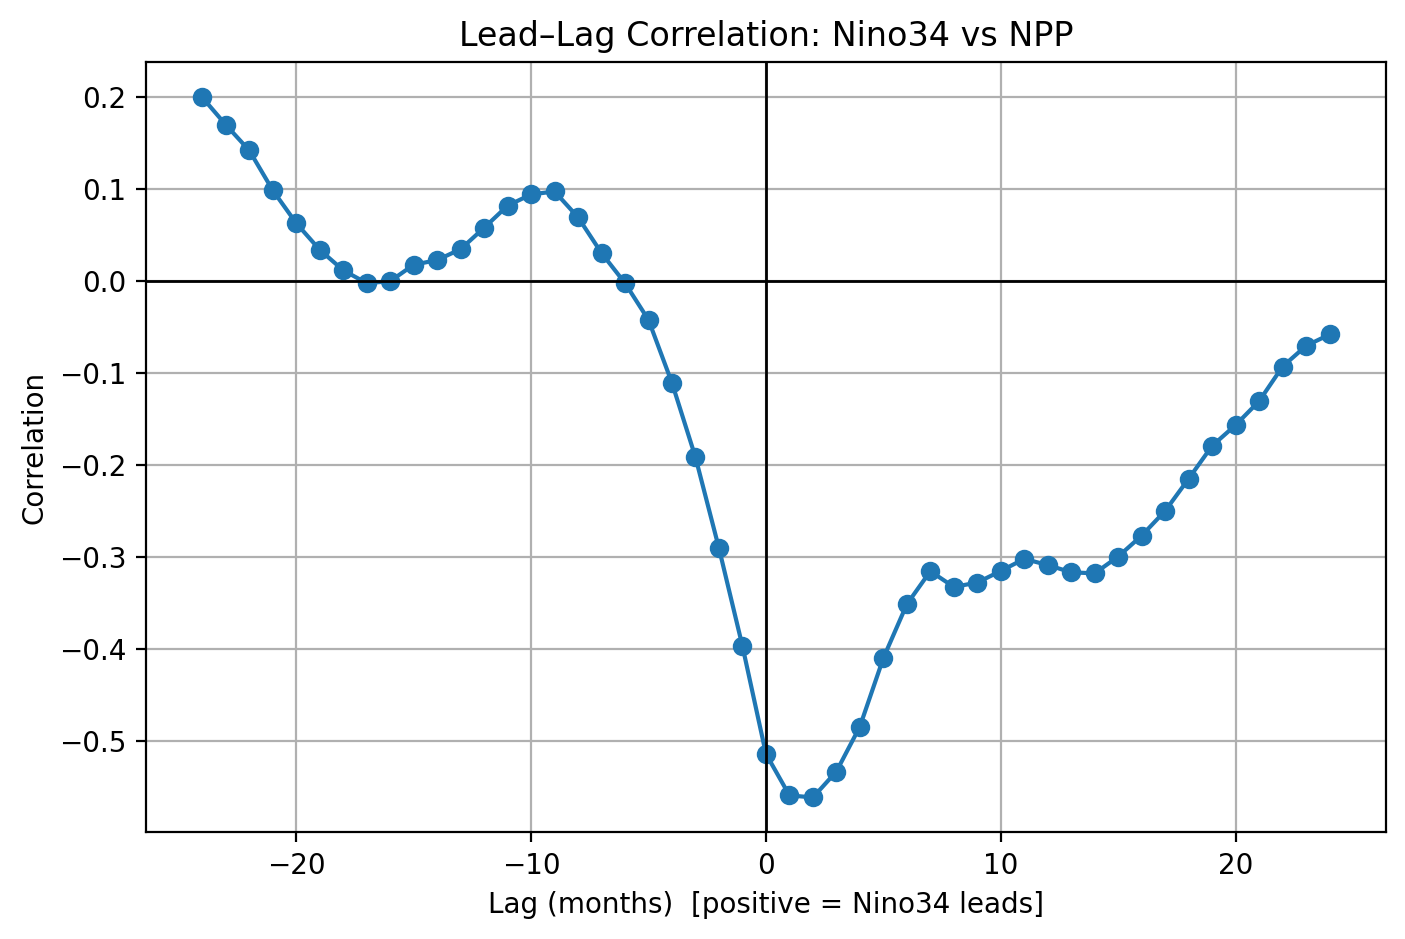

In [9]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# -----------------------------------------
# 1. Load variables
# -----------------------------------------
nino = obs_all['Nino34']
npp  = obs_all['NPP']

# -----------------------------------------
# 2. Remove NaNs
# -----------------------------------------
valid = xr.ufuncs.isfinite(nino) & xr.ufuncs.isfinite(npp)
nino = nino.where(valid, drop=True)
npp  = npp.where(valid, drop=True)

# -----------------------------------------
# 3. Lead–lag correlation
#    lag > 0 : Nino34 leads NPP
#    lag < 0 : NPP leads Nino34
# -----------------------------------------
max_lag = 24  # months
lags = np.arange(-max_lag, max_lag + 1)
corrs = []

for lag in lags:
    if lag > 0:
        # Nino34(t-lag) vs NPP(t)
        corr = xr.corr(nino.shift(time=lag), npp, dim="time")
    elif lag < 0:
        # Nino34(t) vs NPP(t+lag)
        corr = xr.corr(nino, npp.shift(time=-lag), dim="time")
    else:
        # lag = 0
        corr = xr.corr(nino, npp, dim="time")

    corrs.append(corr.values)

corrs = np.array(corrs)

# -----------------------------------------
# 4. Plot
# -----------------------------------------
plt.figure(figsize=(8,5))
plt.plot(lags, corrs, marker='o')

plt.axhline(0, color='k', linewidth=1)
plt.axvline(0, color='k', linewidth=1)

plt.title("Lead–Lag Correlation: Nino34 vs NPP")
plt.xlabel("Lag (months)  [positive = Nino34 leads]")
plt.ylabel("Correlation")
plt.grid(True)

plt.show()


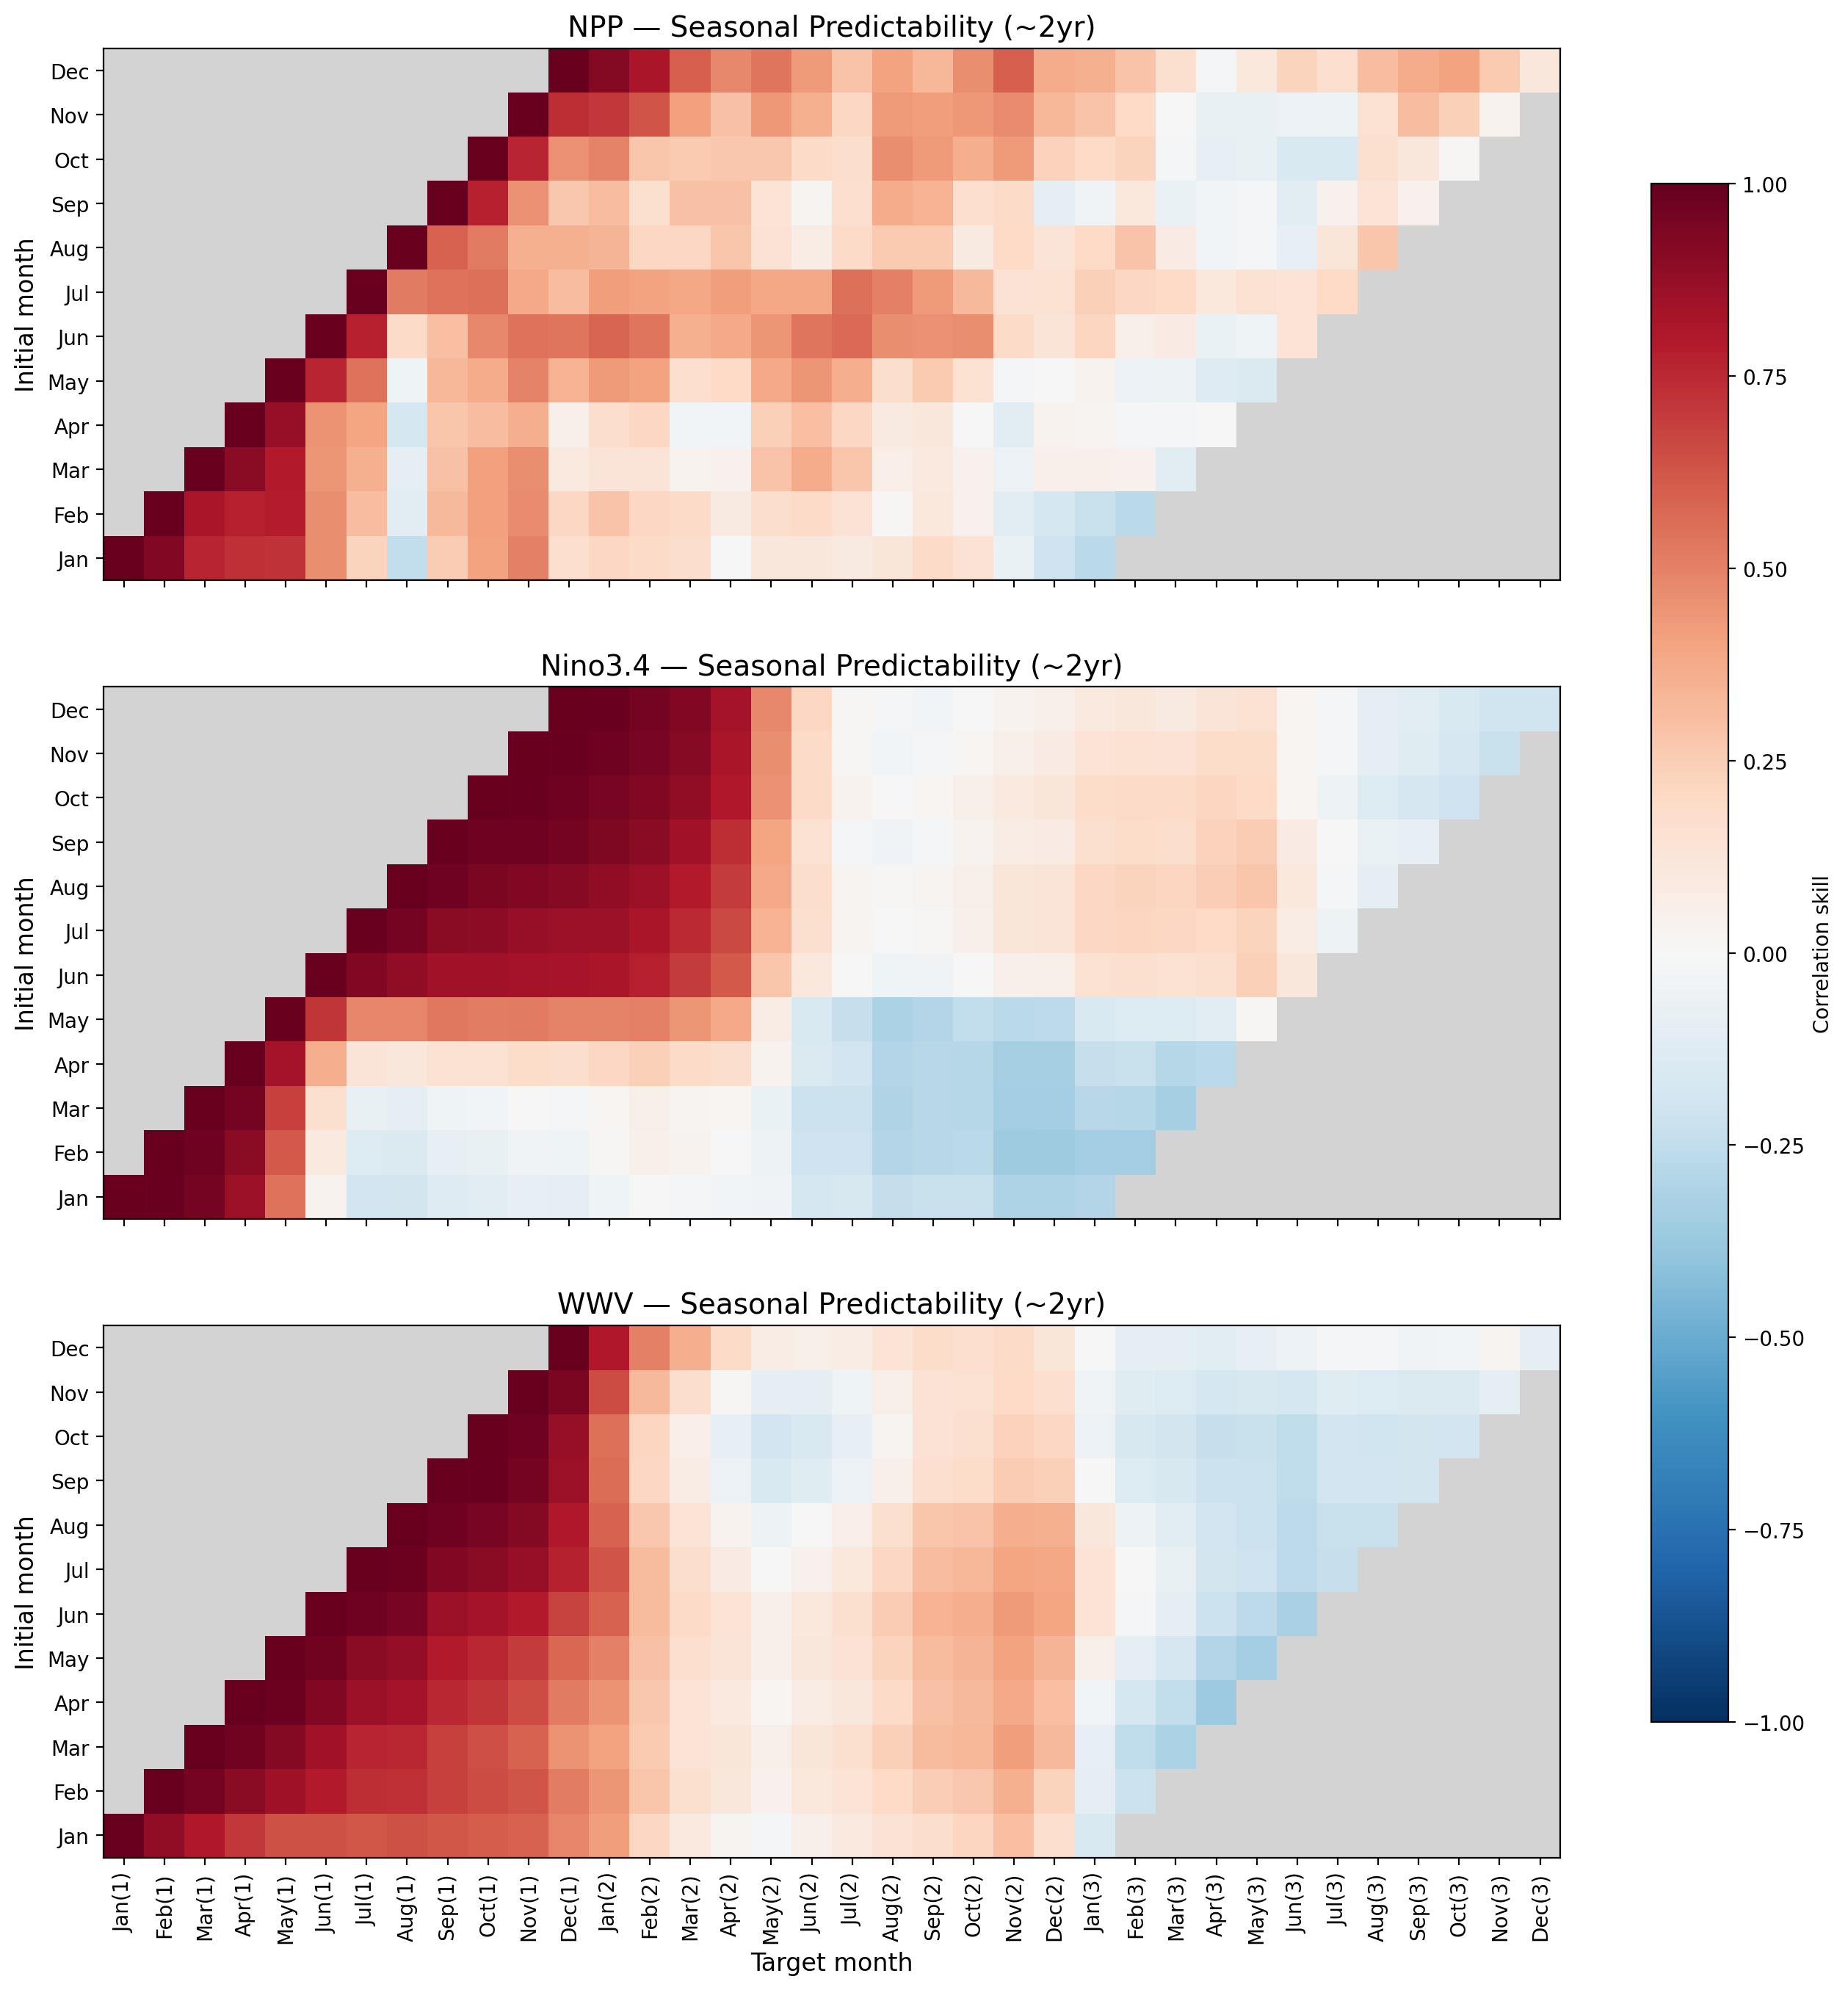

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def oras_multiyear_shifted(da, month, max_lag=24):
    """
    ORAS5/XRO multiyear predictability map aligned by initial month,
    with left-side gray masking and 2-year target timeline.
    """
    m = month.values.astype(int)
    x = da.values
    N = len(x)

    # 1) persistence skill: 12 × (lag+1)
    pers = np.full((12, max_lag+1), np.nan)

    for init_m in range(1, 13):
        idx_init = np.where(m == init_m)[0]

        for lag in range(max_lag+1):
            idx_tgt = idx_init + lag
            idx_tgt = idx_tgt[idx_tgt < N]

            if len(idx_tgt) < 5:
                continue
            
            corr = np.corrcoef(
                x[idx_init[:len(idx_tgt)]],
                x[idx_tgt]
            )[0,1]

            pers[init_m-1, lag] = corr

    # 2) shifted ORAS-style matrix
    W = max_lag + 12   # 12-month shift + 24-month lag (2 years)
    skill = np.full((12, W), np.nan)

    for im in range(1, 13):
        shift = im - 1
        skill[im-1, shift:shift+max_lag+1] = pers[im-1, :]

    return skill


# ------------------------------------------------------
# Variables to plot
# ------------------------------------------------------
vars_to_plot = {
    "NPP": obs_all["NPP"],
    "Nino3.4": obs_all["Nino34"],
    "WWV": obs_all["WWV"]
}

month = obs_all["month"]
max_lag = 24

skills = {name: oras_multiyear_shifted(da, month, max_lag)
          for name, da in vars_to_plot.items()}


# ------------------------------------------------------
# Build target-month labels (2 years)
# ------------------------------------------------------
calendar = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug",
            "Sep","Oct","Nov","Dec"]

labels = []
year = 1
for i in range(max_lag + 12):
    mo = i % 12
    if i > 0 and mo == 0:
        year += 1
    labels.append(f"{calendar[mo]}({year})")


# ------------------------------------------------------
# Panel plot (3 rows)
# ------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(16, 16), sharex=True)

cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad(color='lightgray')

for ax, (name, skill) in zip(axes, skills.items()):

    masked = np.ma.masked_where(np.isnan(skill), skill)

    im = ax.imshow(
        masked, origin="lower", cmap=cmap,
        vmin=-1, vmax=1, aspect="auto"
    )

    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(calendar)

    ax.set_ylabel("Initial month", fontsize=12)
    ax.set_title(f"{name} — Seasonal Predictability (~2yr)", fontsize=14)

# Shared X-axis
axes[-1].set_xticks(np.arange(len(labels)))
axes[-1].set_xticklabels(labels, rotation=90)
axes[-1].set_xlabel("Target month", fontsize=12)

# Single colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85, label="Correlation skill")

# plt.tight_layout()
plt.show()


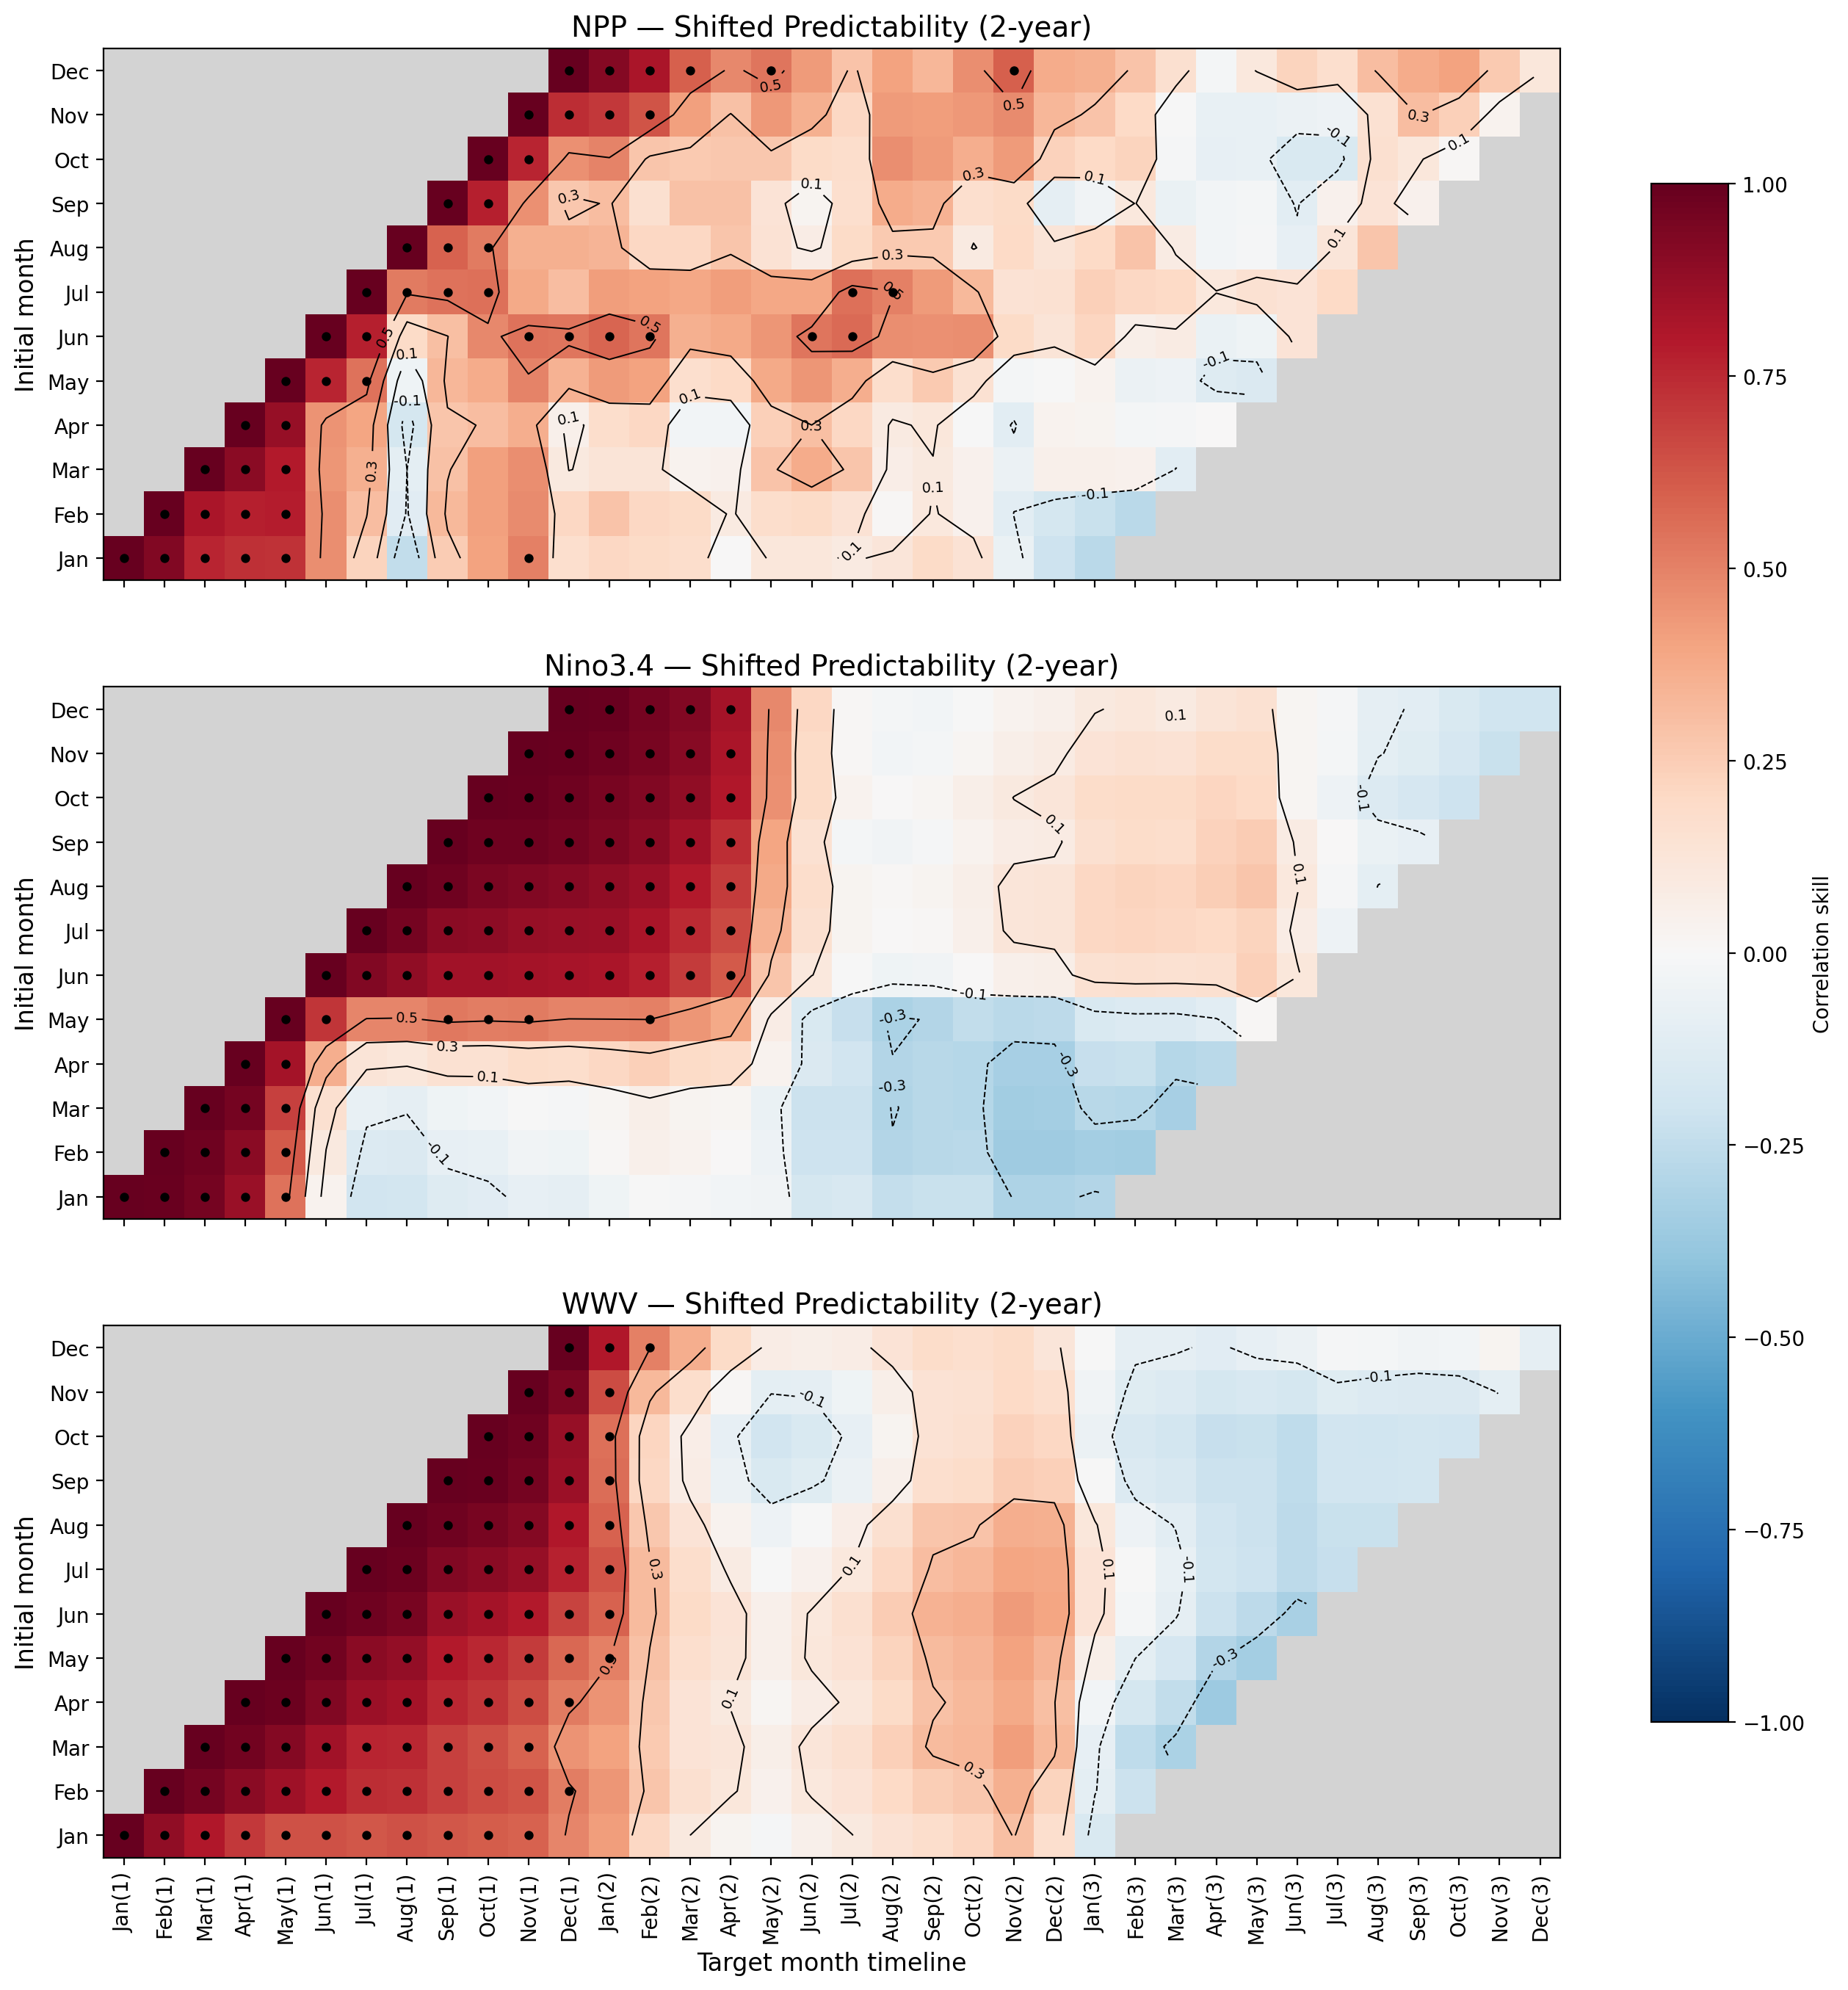

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def oras_multiyear_shifted(da, month, max_lag=24):
    """
    ORAS5/XRO multiyear predictability map aligned by initial month,
    with left-side gray masking and 2-year target timeline.
    """
    m = month.values.astype(int)
    x = da.values
    N = len(x)

    # 1) persistence skill: 12 × (lag+1)
    pers = np.full((12, max_lag+1), np.nan)

    for init_m in range(1, 13):
        idx_init = np.where(m == init_m)[0]

        for lag in range(max_lag+1):
            idx_tgt = idx_init + lag
            idx_tgt = idx_tgt[idx_tgt < N]

            if len(idx_tgt) < 5:
                continue
            
            corr = np.corrcoef(
                x[idx_init[:len(idx_tgt)]],
                x[idx_tgt]
            )[0,1]

            pers[init_m-1, lag] = corr

    # 2) shifted ORAS-style matrix
    W = max_lag + 12   # 12-month shift + 24-month lag (2 years)
    skill = np.full((12, W), np.nan)

    for im in range(1, 13):
        shift = im - 1
        skill[im-1, shift:shift+max_lag+1] = pers[im-1, :]

    return skill


# ------------------------------------------------------
# Variables to plot (3-panel)
# ------------------------------------------------------
vars_to_plot = {
    "NPP": obs_all["NPP"],
    "Nino3.4": obs_all["Nino34"],
    "WWV": obs_all["WWV"],
}

month = obs_all["month"]
max_lag = 24

skills = {name: oras_multiyear_shifted(da, month, max_lag)
          for name, da in vars_to_plot.items()}

# ------------------------------------------------------
# Build target-month labels (2 years)
# ------------------------------------------------------
calendar = ["Jan","Feb","Mar","Apr","May","Jun","Jul",
            "Aug","Sep","Oct","Nov","Dec"]

labels = []
year = 1
for i in range(max_lag + 12):   # 12 month shift + 24 lags
    mo = i % 12
    if i > 0 and mo == 0:
        year += 1
    labels.append(f"{calendar[mo]}({year})")


# ------------------------------------------------------
# Panel plot (3 rows)
# ------------------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(16, 16), sharex=True)

cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad(color='lightgray')

for ax, (name, skill) in zip(axes, skills.items()):

    masked = np.ma.masked_where(np.isnan(skill), skill)

    # --- main heatmap ---
    im = ax.imshow(
        masked, origin="lower", cmap=cmap,
        vmin=-1, vmax=1, aspect="auto"
    )

    # --- contour line ---
    contour_levels = [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]
    CS = ax.contour(
        masked, levels=contour_levels,
        colors='black', linewidths=0.7
    )
    ax.clabel(CS, fmt='%0.1f', fontsize=7)

    # --- dot marker where correlation >= 0.5 ---
    yy, xx = np.where(skill >= 0.5)
    ax.scatter(xx, yy, s=12, color='black', marker='o')

    ax.set_yticks(np.arange(12))
    ax.set_yticklabels(calendar)

    ax.set_ylabel("Initial month", fontsize=12)
    ax.set_title(f"{name} — Shifted Predictability (2-year)", fontsize=14)

# Shared x-axis
axes[-1].set_xticks(np.arange(len(labels)))
axes[-1].set_xticklabels(labels, rotation=90)
axes[-1].set_xlabel("Target month timeline", fontsize=12)

# Single colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85,
                    label="Correlation skill")

# plt.tight_layout()
plt.show()
